# MNIST ConvNet Classifier with WandB Integration 
# 
## Overview:
This project implements a Convolutional Neural Network(CNN) to classify handwritten digits from the MNIST dataset using PyTorch.The project leverages PyTorch's powerful deep learning framework to build and train the CNN model efficiently. A key feature is the integration of Weights & Biases (wandb) for comprehensive experiment tracking and visualization, allowing for detailed monitoring of the training process and model performance. This implementation not only showcases the effectiveness of CNNs in recognizing handwritten digits but also highlights modern practices in machine learning development, including the use of advanced tools for performance tracking and analysis. 

## Requirements
Python 3.x

PyTorch

torchvision

matplotlib

numpy

wandb

## Methodology:
The project follows a structured approach to build and train the CNN model. It starts by loading and preprocessing the MNIST dataset using PyTorch's data loaders. The CNN architecture is then defined, consisting of two convolutional layers and two fully connected layers, with ReLU activation and max pooling. The model is trained using the Adam optimizer and Negative Log Likelihood Loss function. The training process is conducted over 10 epochs with a batch size of 512. Importantly, the project integrates Weights & Biases (wandb) for comprehensive experiment tracking and visualization, allowing for detailed monitoring of the training process and model performance.

## Results:
The MNIST ConvNet Classifier achieves impressive results after 10 epochs of training. The model attains a test accuracy of 98.95% and a test loss of 0.03433, demonstrating its effectiveness in classifying handwritten digits. These results are meticulously tracked and visualized using wandb, providing comprehensive insights into the model's performance over time. The integration of wandb not only facilitates easy monitoring of training progress but also enables detailed analysis of loss and accuracy metrics, making it an invaluable tool for model development and optimization.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import wandb 

In [2]:
wandb.init(project="mnist_convnet", name="ConvNet_MNIST")

BATCH_SIZE = 512
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: amogh-ajith (amogh-ajith-amrita-vishwa-vidyapeetham). Use `wandb login --relogin` to force relogin


In [3]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True, 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=BATCH_SIZE, shuffle=True)



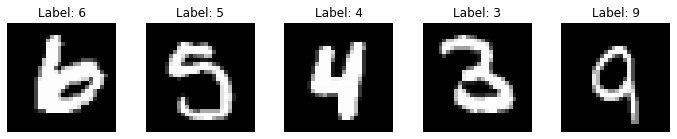

In [4]:
def show_sample_images(data_loader):
    batch = next(iter(data_loader))  
    images, labels = batch  
    images = images[:5]
    labels = labels[:5]

    fig, axes = plt.subplots(1, 5, figsize=(12, 2))
    for i in range(5):
        image = images[i].numpy().squeeze()
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'Label: {labels[i].item()}')
        axes[i].axis('off')
    plt.show()

show_sample_images(train_loader)



In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.fc1 = nn.Linear(20*10*10, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        in_size = x.size(0)
        out = self.conv1(x)
        out = F.relu(out)
        out = F.max_pool2d(out, 2, 2)
        out = self.conv2(out)
        out = F.relu(out)
        out = out.view(in_size, -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.log_softmax(out, dim=1)
        return out



In [6]:
model = ConvNet().to(DEVICE)
optimizer = optim.Adam(model.parameters())



In [7]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()


        wandb.log({"train_loss": loss.item()})

        if (batch_idx + 1) % 30 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')



In [8]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)


    wandb.log({"test_loss": test_loss, "accuracy": accuracy})

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({accuracy:.0f}%)\n')



In [9]:
for epoch in range(1, EPOCHS + 1):
    train(model, DEVICE, train_loader, optimizer, epoch)
    test(model, DEVICE, test_loader)


wandb.finish()


Train Epoch: 1 [14848/60000 (25%)]	Loss: 0.354362
Train Epoch: 1 [30208/60000 (50%)]	Loss: 0.183917
Train Epoch: 1 [45568/60000 (75%)]	Loss: 0.163156

Test set: Average loss: 0.0954, Accuracy: 9719/10000 (97%)

Train Epoch: 2 [14848/60000 (25%)]	Loss: 0.085585
Train Epoch: 2 [30208/60000 (50%)]	Loss: 0.074752
Train Epoch: 2 [45568/60000 (75%)]	Loss: 0.096309

Test set: Average loss: 0.0567, Accuracy: 9812/10000 (98%)

Train Epoch: 3 [14848/60000 (25%)]	Loss: 0.036750
Train Epoch: 3 [30208/60000 (50%)]	Loss: 0.063170
Train Epoch: 3 [45568/60000 (75%)]	Loss: 0.061121

Test set: Average loss: 0.0494, Accuracy: 9837/10000 (98%)

Train Epoch: 4 [14848/60000 (25%)]	Loss: 0.034941
Train Epoch: 4 [30208/60000 (50%)]	Loss: 0.043670
Train Epoch: 4 [45568/60000 (75%)]	Loss: 0.050178

Test set: Average loss: 0.0455, Accuracy: 9851/10000 (99%)

Train Epoch: 5 [14848/60000 (25%)]	Loss: 0.024151
Train Epoch: 5 [30208/60000 (50%)]	Loss: 0.059742
Train Epoch: 5 [45568/60000 (75%)]	Loss: 0.030040

Test 

accuracy,▁▅▆▆▇██▇██
test_loss,█▄▃▃▁▁▁▂▁▁
train_loss,█▄▄▄▃▃▃▂▃▃▂▂▂▂▁▂▂▂▂▁▂▁▁▁▁▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁
accuracy,98.95
test_loss,0.03433
train_loss,0.00511
